<a href="https://colab.research.google.com/github/simonsavine/phasetype/blob/main/markov_chain_simulation_continuous_time.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [162]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm

In [163]:
# Helper functions

In [164]:
def is_square(Q):
  shape = np.shape(Q)

  if len(shape) != 2:
    return False

  return shape[0] == shape[1]

In [165]:
def is_proba_vector(P):
  if np.any(P < 0):
    return False

  return np.isclose(np.sum(P),1)

In [166]:
# we only accept n by n intensity matrices with exactly 1 absorbing state n
def is_intensity_matrix(Q):
  if not is_square(Q):
    return False

  # check that off-diagonals are non-negative
  n = np.shape(Q)[0]
  for j in range(n):
    for k in range(j):
      if Q[j, k] < 0 or Q[k, j] < 0:
        return False

  # check diagonals
  diag = np.diag(Q)
  # last diagonal must be 0 (absorbing)
  if diag[-1] != 0:
    return False
  # all other diagonals must be non-zero (non-absorbing)
  if np.any(diag[:-1] >= -1e-8):
    return False

  # check that all columns sum to 0
  if np.allclose(Q.sum(axis=1), 0):
    return False

  return True

In [167]:
def is_diagonalizable(Q):
  if not is_square(Q):
    return False

  ls, V = np.linalg.eig(Q)

  return np.abs(np.linalg.det(V)) > 1e-4

In [168]:
def make_random_probability_vector(n):
  P = np.random.uniform(size=n)
  return P / P.sum()


# we draw intensities with exponential distribution
# by default, scale = 1, lambda = 4
def make_random_intensity_matrix(n, scale = 1, absorbing=True, diagonalizable=True):
  # random intensities between 0 and 1
  Q = np.random.exponential(scale = scale, size = (n, n))
  # set diagonal intensities such that columns sum to 0
  for k in range(n):
    Q[k, k] = 0
    Q[k, k] = - Q[:, k].sum()
  # absorbing column
  if absorbing:
    Q[:, n-1] = 0

  if diagonalizable and not is_diagonalizable(Q):
    return make_random_intensity_matrix(n, scale, absorbing, True)

  return Q




In [169]:
# End of elper functions

In [170]:
class CTMC:

  def __init__(self, P0, Q):

    assert is_proba_vector(P0), 'not a probability vector'
    assert is_intensity_matrix(Q), 'not an intensity matrix'
    assert is_diagonalizable(Q), 'not diagonalizable'
    assert P0.shape[0] == Q.shape[0], 'inconsistent shapes'

    self.n = np.shape(Q)[0]

    self.P0 = P0
    self.Q = Q
    self.lams, self.V = np.linalg.eig(Q)
    self.invV = np.linalg.inv(self.V)

  # 1. helper to compute exp(Q t), see section 1.1 of document

  # calculate exp(Qt)
  def calc_matrix_exp(self, t):
    # dump (numerical) imaginary part, eigenvalues of intensity matrices are always real
    return np.real(self.V @ np.diag(np.exp(self.lams * t)) @ self.invV)

  # 2. compute probabilities of CTMC states, and absorption time
  # see sections 2 and 3

  # calculate P(T2) as a function of P(T1)
  def calc_probas(self, T2, T1=0., P1 = None):
    if P1 is None:
      P1 = self.P0
    return self.calc_matrix_exp(T2 - T1) @ P1

  # calculate Pr(X2 | X1 = k)
  def calc_probas_definitestate(self, delta_T, k):
    return self.self.calc_matrix_exp(delta_T) [:, k]

  # calculate distribution of absorption time (i.e. Phase-Type)
  def calc_phase_type_cdf(self, t):
    return self.calc_probas(t)[-1]
  def calc_phase_type_pdf(self, t):
    return (self.calc_matrix_exp(t) @ self.Q @ self.P0)[-1]

  # simulate CTMC and sample absorption time, see section 4

  # draw holding time
  def draw_holding_time(self, k):
    return np.random.exponential(scale = - 1 / self.Q[k, k])

  # draw next state
  def draw_next_state(self, k):
    probas = - self.Q[:, k] / self.Q[k, k]
    probas[k] = 0
    return np.random.choice(self.n, p = probas)

  def sample_path(self):
    # draw initial state
    time = 0
    state = np.random.choice(self.n, p=self.P0)
    path = [(time, state)]

    # iterate until hitting absorbing state
    while state != self.n-1:
      tau = self.draw_holding_time(state)
      time += tau
      state = self.draw_next_state(state)
      path.append((time, state))

    return np.array(path).T

  def sample_paths(self, N=1000):
    paths = []
    for _ in tqdm.tqdm(range(N)):
      paths.append(self.sample_path())
    return paths



In [171]:
# first tests

In [208]:
# pick P0 and Q

n = 4
P0 = make_random_probability_vector(n)
Q = make_random_intensity_matrix(n)

In [209]:
P0

array([0.32408362, 0.51063714, 0.13841181, 0.02686743])

In [210]:
Q

array([[-1.36541951,  2.80742967,  0.32159156,  0.        ],
       [ 0.12102277, -3.50583472,  0.31075694,  0.        ],
       [ 0.09255567,  0.33950404, -1.65552051,  0.        ],
       [ 1.15184108,  0.35890102,  1.023172  ,  0.        ]])

In [240]:
# sample a path
ctmc = CTMC(P0, Q)
ctmc.sample_path()

array([[0.        , 0.27627849, 0.60422601, 0.69601773, 1.06523361],
       [1.        , 2.        , 1.        , 0.        , 3.        ]])

In [245]:
# sample multiple paths
ctmc.sample_paths(5)

100%|██████████| 5/5 [00:00<00:00, 2069.42it/s]


[array([[0.        , 0.08745425, 0.75201508],
        [2.        , 0.        , 3.        ]]),
 array([[0.        , 0.157203  , 0.70991298],
        [1.        , 0.        , 3.        ]]),
 array([[0.        , 0.0373057 , 1.13315944],
        [1.        , 0.        , 3.        ]]),
 array([[0.        , 0.17753227, 0.34555349, 0.61035853, 0.7823253 ,
         0.88965603, 2.32505906, 3.27647044],
        [1.        , 0.        , 2.        , 0.        , 1.        ,
         0.        , 2.        , 3.        ]]),
 array([[0.        , 0.40776203, 1.52554995],
        [1.        , 0.        , 3.        ]])]

In [213]:
# helper functions to analyse paths

In [214]:
def get_state(path, t):
  times = path[0, :]
  states = path[1, :].astype(int)
  return states[np.searchsorted(times, t, side="right") - 1]

In [215]:
def get_absorption_time(path):
  times = path[0, :]
  return times[-1]

In [281]:
# sample 100,000 paths
N = 100000
paths = ctmc.sample_paths(N)

100%|██████████| 100000/100000 [00:09<00:00, 10062.05it/s]


In [247]:
# check state probabilities

In [282]:
t = 1
theoretical_probas = ctmc.calc_probas(t)
theoretical_probas

array([0.27765572, 0.03369202, 0.06103549, 0.62761676])

In [286]:
states_at_t = [get_state(path, t) for path in paths]
absorption_times = [get_absorption_time(path) for path in paths]

In [289]:
# helper function computes empirical frequencies
def compute_empirical_freqs(sample):
  states, counts = np.unique(sample, return_counts=True)
  freqs = counts / np.sum(counts)
  return freqs

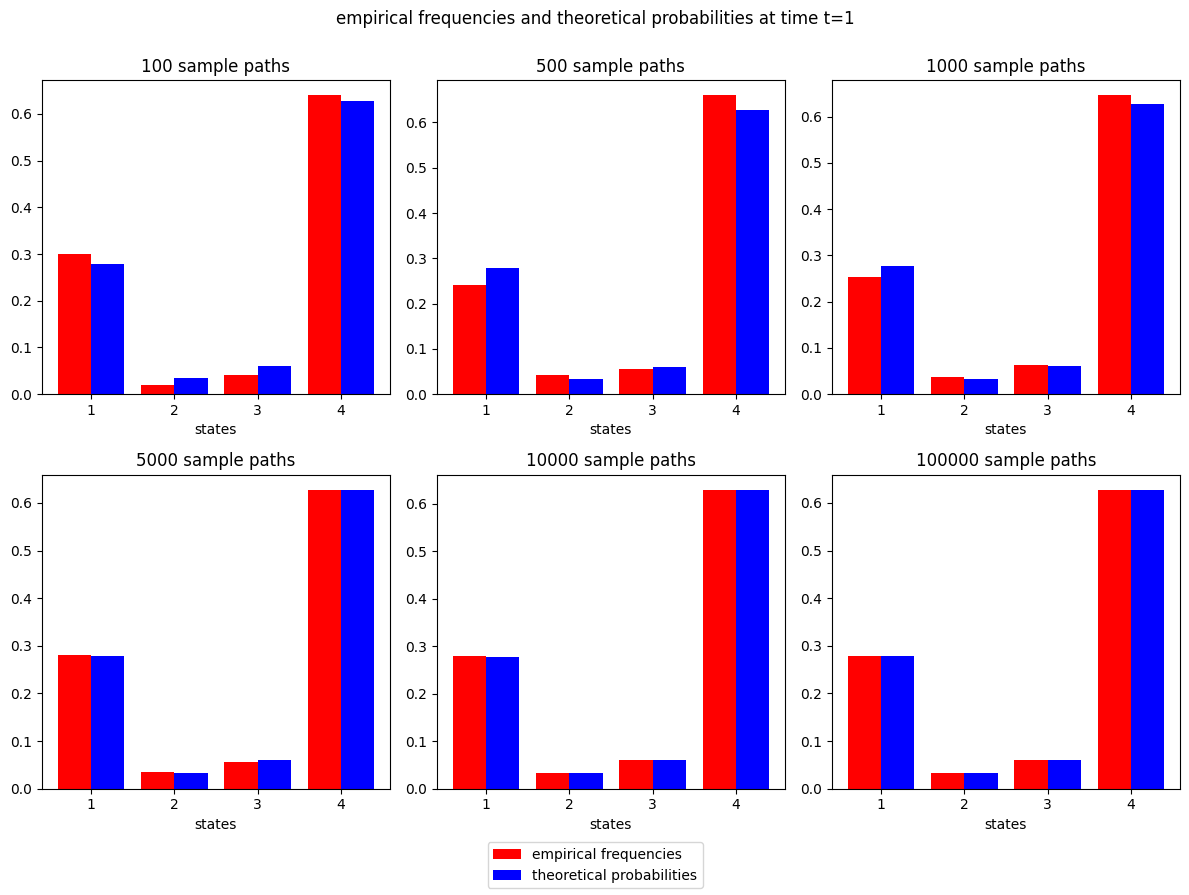

In [290]:
states = np.arange(n)
fig, axs = plt.subplots(2, 3, figsize=(12, 9))
axs = axs.flatten()
Ms = [100, 500, 1000, 5000, 10000, 100000]
for ax, M in zip(axs, Ms):
  ax.bar(states + 0.8, compute_empirical_freqs(states_at_t[:M]), 0.4, color='r', label = 'empirical frequencies')
  ax.bar(states + 1.2, theoretical_probas, 0.4, color='b', label = 'theoretical probabilities')
  ax.set_xlabel("states")
  ax.set_title(f"{M} sample paths")

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center")
fig.suptitle("empirical frequencies and theoretical probabilities at time t=1")
plt.tight_layout(rect=[0, 0.05, 1, 0.98])

In [307]:
# check distribution of absorption time
lower = 0
higher = np.max(absorption_times)
times = np.linspace(lower, higher, 1000)
theoretical_densities = [ctmc.calc_phase_type_pdf(t) for t in times]

In [308]:
# helper function computes empirical density
def compute_empirical_densities(sample, lower, higher):
  bins = min(len(sample) // 10, 200)
  ts = np.linspace(lower, higher, bins) + 1e-8
  h = (higher - lower) / bins
  empirical_densities = [0]
  for i in range(1, len(ts)):
    t0 = ts[i-1]
    t1 = ts[i]
    count = np.count_nonzero((sample >=t0) & (sample < t1))
    empirical_densities.append(count)
  empirical_densities = np.array(empirical_densities) / h / len(sample)
  empirical_densities[0] = empirical_densities[1]
  return ts, empirical_densities

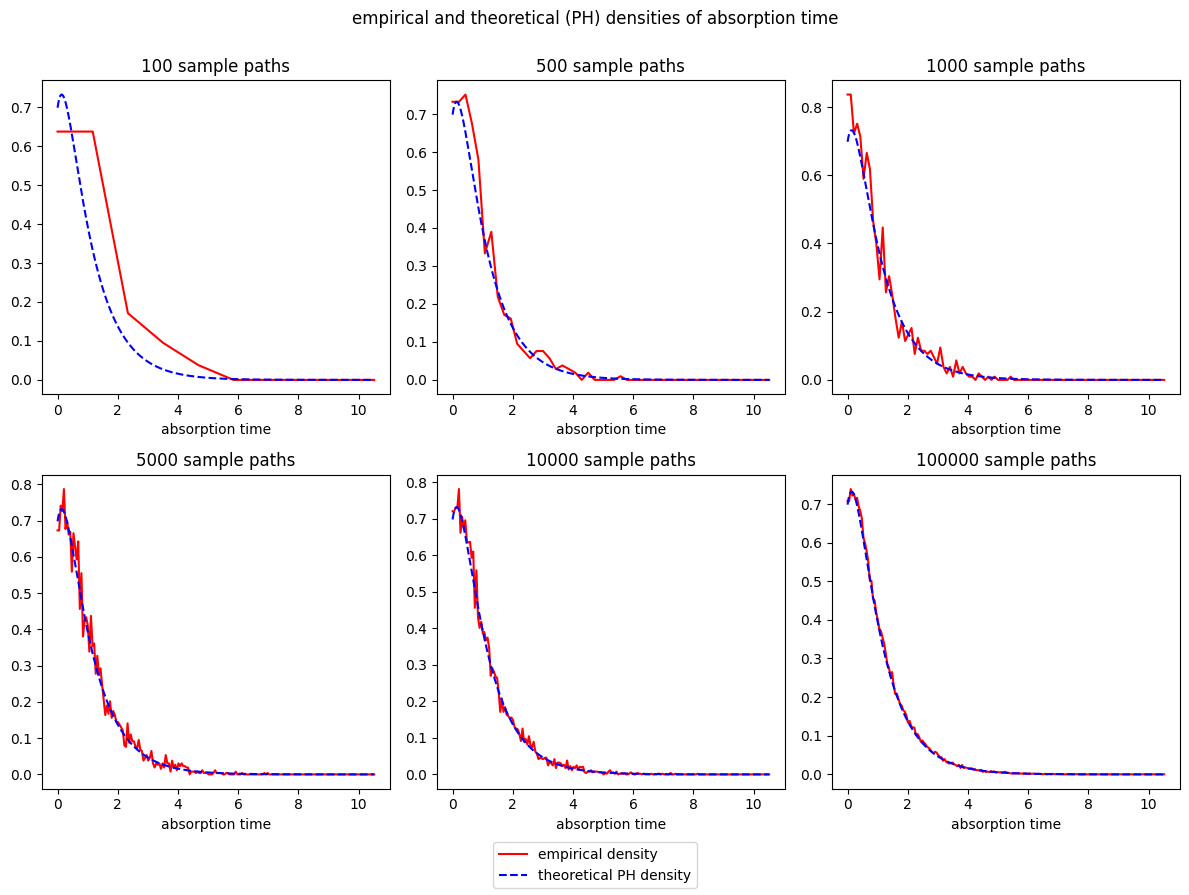

In [311]:
fig, axs = plt.subplots(2, 3, figsize=(12, 9))
axs = axs.flatten()
Ms = [100, 500, 1000, 5000, 10000, 100000]
for ax, M in zip(axs, Ms):
  ts, empirical_densities = compute_empirical_densities(absorption_times[:M], lower, higher)
  ax.plot(ts, empirical_densities, color='r', label = 'empirical density')
  ax.plot(times, theoretical_densities, color='b', linestyle="--", label = 'theoretical PH density')
  ax.set_xlabel("absorption time")
  ax.set_title(f"{M} sample paths")

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center")
fig.suptitle("empirical and theoretical (PH) densities of absorption time")
plt.tight_layout(rect=[0, 0.05, 1, 0.98])